In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
import torchvision.transforms as transforms
import torchvision.io 
import librosa
from PIL import Image
import albumentations as alb
import torch.multiprocessing as mp
import warnings

warnings.filterwarnings('ignore')

In [139]:
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping

In [140]:
class Config:
    use_aug = False
    num_classes = 264
    batch_size = 64
    epochs = 12
    PRECISION = 16    
    PATIENCE = 8    
    seed = 2023
    model = "tf_efficientnet_b0_ns"
    pretrained = True            
    weight_decay = 1e-3
    use_mixup = True
    mixup_alpha = 0.2   
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

    data_root = "../data/"
    train_images = "specs/train/"
    valid_images = "specs/valid/"
    train_path = "train.csv"
    valid_path = "valid.csv"
    
    
    SR = 32000
    DURATION = 5
    MAX_READ_SAMPLES = 5
    LR = 5e-4

In [141]:
pl.seed_everything(Config.seed, workers=True)

Seed set to 2023


2023

In [142]:
def config_to_dict(cfg):
    return dict((name, getattr(cfg, name)) for name in dir(cfg) if not name.startswith('__'))

In [143]:
df_train = pd.read_csv(Config.train_path)
df_valid = pd.read_csv(Config.valid_path)
df_train.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,len_sec_labels,path,frames,sr,duration
0,litegr,[],"['alarm call', 'flight call']",43.8559,1.7856,Egretta garzetta,Little Egret,Cedric Mroczko,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/576994,litegr/XC576994.ogg,0,../data/train_audio/litegr/XC576994.ogg,194769,32000,6.086531
1,spodov,"['houspa', 'rewbul']",['song'],-20.4338,57.4578,Streptopelia chinensis,Spotted Dove,Cedric Mroczko,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/463317,spodov/XC463317.ogg,2,../data/train_audio/spodov/XC463317.ogg,130560,32000,4.080000
2,comsan,[],[''],43.5652,4.5811,Actitis hypoleucos,Common Sandpiper,Manceau Lionel,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://xeno-canto.org/764652,comsan/XC764652.ogg,0,../data/train_audio/comsan/XC764652.ogg,604416,32000,18.888000
3,eaywag1,[],['flight call'],53.5337,-1.7832,Motacilla flava,Western Yellow Wagtail,David Pennington,Creative Commons Attribution-NonCommercial-Sha...,4.0,http://xeno-canto.org/675728,eaywag1/XC675728.ogg,0,../data/train_audio/eaywag1/XC675728.ogg,733936,32000,22.935500
4,greegr,[],"['flight call', 'life stage uncertain', 'sex u...",51.8056,16.6515,Ardea alba,Great Egret,Grzegorz Lorek,Creative Commons Attribution-NonCommercial-Sha...,3.0,http://xeno-canto.org/678629,greegr/XC678629.ogg,0,../data/train_audio/greegr/XC678629.ogg,195072,32000,6.096000


In [144]:
Config.num_classes = len(df_train.primary_label.unique())

In [145]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['primary_label'])], axis=1)
df_valid = pd.concat([df_valid, pd.get_dummies(df_valid['primary_label'])], axis=1)

# Take a subset 
df_train = df_train.sample(n=100)
df_valid = df_valid.sample(n=100)

In [170]:
birds = list(df_train.primary_label.unique())
missing_birds = list(set(list(df_train.primary_label.unique())).difference(list(df_valid.primary_label.unique())))

In [148]:
non_missing_birds = list(set(list(df_train.primary_label.unique())).difference(missing_birds))

In [149]:
len(non_missing_birds)

32

In [150]:
df_valid[missing_birds] = 0
df_valid = df_valid[df_train.columns] ## Fix order

In [171]:
import albumentations as A
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
                A.Cutout(max_h_size=5, max_w_size=16),
                A.CoarseDropout(max_holes=4),
            ], p=0.5),
    ])

In [152]:
class BirdDataset(torch.utils.data.Dataset):

    def __init__(self, df, sr = Config.SR, duration = Config.DURATION, augmentations = None, train = True):

        self.df = df
        self.sr = sr 
        self.train = train
        self.duration = duration
        self.augmentations = augmentations
        if train:
            self.img_dir = Config.train_images
        else:
            self.img_dir = Config.valid_images

    def __len__(self):
        return len(self.df)

    @staticmethod
    def normalize(image):
        image = image / 255.0
        #image = torch.stack([image, image, image])
        return image

    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        impath = self.img_dir + f"{row.filename}.npy"

        image = np.load(str(impath))[:Config.MAX_READ_SAMPLES]
        
        ########## RANDOM SAMPLING ################
        if self.train:
            image = image[np.random.choice(len(image))]
        else:
            image = image[0]
            
        #####################################################################
        
        image = torch.tensor(image).float()

        if self.augmentations:
            image = self.augmentations(image.unsqueeze(0)).squeeze()
            
        image.size()
        
        image = torch.stack([image, image, image])

        image = self.normalize(image)


        return image, torch.tensor(row[17:]).float()

In [153]:
def get_fold_dls(df_train, df_valid):

    ds_train = BirdDataset(
        df_train, 
        sr = Config.SR,
        duration = Config.DURATION,
        augmentations = None,
        train = True
    )
    ds_val = BirdDataset(
        df_valid, 
        sr = Config.SR,
        duration = Config.DURATION,
        augmentations = None,
        train = False
    )
    dl_train = DataLoader(ds_train, batch_size=Config.batch_size , shuffle=True, num_workers = 2)    
    dl_val = DataLoader(ds_val, batch_size=Config.batch_size, num_workers = 2)
    return dl_train, dl_val, ds_train, ds_val

In [154]:
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(12, 6))    
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img, lb = img_ds[img_index]        
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            img = img.transpose(1, 2, 0)
            ax.imshow(img)        
            
        title = f"Spec"
        ax.set_title(title)  

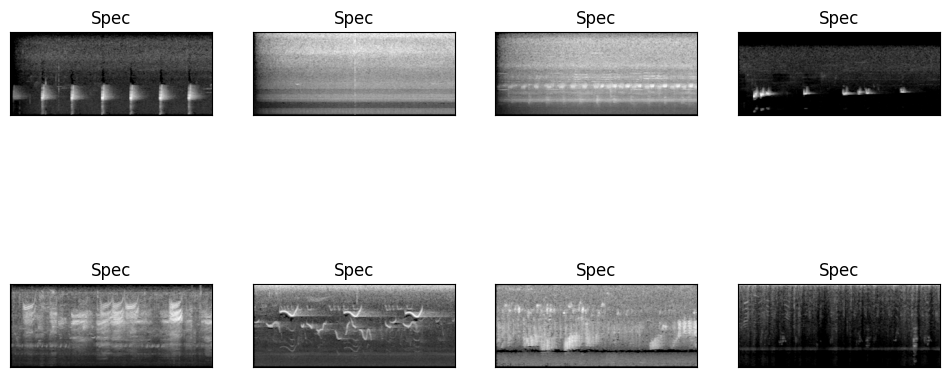

In [155]:
dl_train, dl_val, ds_train, ds_val = get_fold_dls(df_train, df_valid)
show_batch(ds_val, 8, 2, 4)

In [156]:
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR

def get_optimizer(lr, params):
    model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=Config.weight_decay
        )
    interval = "epoch"
    
    lr_scheduler = CosineAnnealingWarmRestarts(
                            model_optimizer, 
                            T_0=Config.epochs, 
                            T_mult=1, 
                            eta_min=1e-6, 
                            last_epoch=-1
                        )

    return {
        "optimizer": model_optimizer, 
        "lr_scheduler": {
            "scheduler": lr_scheduler,
            "interval": interval,
            "monitor": "val_loss",
            "frequency": 1
        }
    }

In [157]:
from torchtoolbox.tools import mixup_data, mixup_criterion
import torch.nn as nn
from torch.nn.functional import cross_entropy
import torchmetrics
import timm

In [158]:
import sklearn.metrics

def padded_cmap(solution, submission, padding_factor=5):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

def map_score(solution, submission):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    score = sklearn.metrics.average_precision_score(
        solution.values,
        submission.values,
        average='micro',
    )
    return score

In [159]:
dummy = df_valid[birds].copy()
dummy[birds] = np.random.rand(dummy.shape[0],dummy.shape[1])

In [160]:
padded_cmap(df_valid[birds], dummy[birds], padding_factor = 5)

0.8832877189308369

In [161]:
padded_cmap(df_valid[birds], dummy[birds], padding_factor = 1)

0.6920246927645641

In [162]:
# map_score(df_valid[birds], dummy[birds])

In [125]:
Config.num_classes

182

In [166]:
class BirdClefModel(pl.LightningModule):
    def __init__(self, model_name=Config.model, num_classes = Config.num_classes, pretrained = Config.pretrained):
        super().__init__()
        self.num_classes = num_classes

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if 'res' in model_name:
            self.in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(self.in_features, num_classes)
        elif 'dense' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Linear(self.in_features, num_classes)
        elif 'efficientnet' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Sequential(
                nn.Linear(self.in_features, num_classes)
            )
        
        self.loss_function = nn.BCEWithLogitsLoss() 

    def forward(self,images):
        logits = self.backbone(images)
        return logits
        
    def configure_optimizers(self):
        return get_optimizer(lr=Config.LR, params=self.parameters())

    def train_with_mixup(self, X, y):
        X, y_a, y_b, lam = mixup_data(X, y, alpha=Config.mixup_alpha)
        y_pred = self(X)
        loss_mixup = mixup_criterion(cross_entropy, y_pred, y_a, y_b, lam)
        return loss_mixup

    def training_step(self, batch, batch_idx):
        image, target = batch        
        if Config.use_mixup:
            loss = self.train_with_mixup(image, target)
        else:
            y_pred = self(image)
            loss = self.loss_function(y_pred,target)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        image, target = batch     
        y_pred = self(image)
        val_loss = self.loss_function(y_pred, target)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        
        return {"val_loss": val_loss, "logits": y_pred, "targets": target}
    
    def train_dataloader(self):
        return self._train_dataloader 
    
    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_batch_end(self, outputs, batch, batch_idx, dataloader_idx=0):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        output_val = torch.cat([x['logits'] for x in outputs],dim=0).sigmoid().cpu().detach().numpy()
        target_val = torch.cat([x['targets'] for x in outputs],dim=0).cpu().detach().numpy()
        
        # print(output_val.shape)
        val_df = pd.DataFrame(target_val, columns = birds)
        pred_df = pd.DataFrame(output_val, columns = birds)
        
        avg_score = padded_cmap(val_df, pred_df, padding_factor = 5)
        avg_score2 = padded_cmap(val_df, pred_df, padding_factor = 3)
        avg_score3 = sklearn.metrics.label_ranking_average_precision_score(target_val,output_val)
        
#         competition_metrics(output_val,target_val)
        print(f'epoch {self.current_epoch} validation loss {avg_loss}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 5 {avg_score}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 3 {avg_score2}')
        print(f'epoch {self.current_epoch} validation AP score {avg_score3}')
        
        
        val_df.to_pickle('val_df.pkl')
        pred_df.to_pickle('pred_df.pkl')
        
        
        return {'val_loss': avg_loss,'val_cmap':avg_score}
    

In [167]:
from pytorch_lightning.loggers import WandbLogger
import gc

def run_training():
    print(f"Running training...")
    logger = None
    
    
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(df_train, df_valid)
    
    audio_model = BirdClefModel()

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=Config.PATIENCE, verbose= True, mode="min")
    checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                          dirpath= "/kaggle/working/exp1/",
                                      save_top_k=1,
                                      save_last= True,
                                      save_weights_only=True,
                                      filename= f'./{Config.model}_loss',
                                      verbose= True,
                                      mode='min')
    
    callbacks_to_use = [checkpoint_callback,early_stop_callback]


    trainer = pl.Trainer(
        # gpus=0,
        val_check_interval=0.5,
        deterministic=True,
        max_epochs=Config.epochs,
        logger=logger,
        # auto_lr_find=False,    
        callbacks=callbacks_to_use,
        # precision=Config.PRECISION, accelerator="gpu" 
    )

    print("Running trainer.fit")
    trainer.fit(audio_model, train_dataloaders = dl_train, val_dataloaders = dl_val)                

    gc.collect()
    torch.cuda.empty_cache()

In [168]:
run_training()

Running training...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | EfficientNet      | 4.2 M 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.963    Total estimated model params size (MB)


Running trainer.fit


Sanity Checking: |                                                                                            …

TypeError: string indices must be integers, not 'str'